# Week 4: Tasks

1. Find helpers for visualization and loading data in `helpers.py`. Please make sure to go through them so you understand their purpose. Feel free to tweak these or add your ones.

2. First approach the theoretical tasks to make sure you can understand and frame the problems correctly.

3. Solve the programming tasks making use of the helpers.

---

## Theoretical Tasks: framing convex programs

Write up your solutions (brief explanations) in markdown.



**Problem 0: Were you listening?**

For each of the following optimization problems:
1. State whether it is a **convex optimization problem** or **not**.
2. Justify your answer briefly (one sentence is enough).

#### (a)
$$
\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & x^\top Q x + c^\top x \\
\text{s.t.} \quad & Ax = b
\end{aligned}
$$

where $Q \succeq 0$, $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^m$.

#### (b)
$$
\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & \|x\|_2^2 \\
\text{s.t.} \quad & \|Ax\|_2 \ge 1
\end{aligned}
$$
where $A \in \mathbb{R}^{m \times n}$.

#### (c)
$$
\begin{aligned}
\max_{w \in \mathbb{R}^n} \quad & (\mu^\top w)(\mathbf{1}^\top w) \\
\text{s.t.} \quad & w \ge 0
\end{aligned}
$$

where $\mu \in \mathbb{R}^n$ is fixed.

---

**Problem 1: Minimum-norm Feasibility**
  
You are given a system of linear equations $Cx=d$, where $C\in\mathbb{R}^{k\times n}$ has full row rank and $d\in\mathbb{R}^k$.  
Among all vectors $x$ that satisfy the constraints, you wish to select one that is in some sense “small”.

1. Formulate this task as a **convex optimization problem**.
2. Argue why the problem is feasible and has a unique solution.
3. *(Bonus)* Derive a closed-form expression for the optimal solution.

*Hints*  
- What properties must the objective function satisfy? Try reasoning about it to come up with a metric that preserves these properties and is convex.
- Lagrange multipliers and first-order optimality conditions are sufficient to solve the problem explicitly (part 3).

---


> Type in your answers here. You may write it in plaintext or paste pictures, but \$ math formatting is preferred.

(a)this is a convex optimization problem ,the quadratic term is convex. The constraint Ax=b is linear, which keeps the problem convex.

(b) No, not a convex optimization problem ,objective function is convex and the constraint ||Ax||>=1 creates a non-convex feasible region.

(c) No, not a convex optimization problem as The objective is a product of two linear functions, which is neither convex nor concave.


---

## Task 0: Store week 2/3 data and read it in
Use helpers to store your expected returns and risk data along with tickers, and read them to load them into this notebook.

See usage in `intro_to_cvxpy.ipynb` in the fully solved example.

NOTE: The week 2 models only predict expected returns ($\hat\mu$), we compute $\hat\Sigma$ as simple covariance matrix of the tickers' returns data for now. In reality predicting $\hat\Sigma$ is a big challenge (perhaps bigger than predicting $\hat\mu$) but we overlook those concerns for now.

For eg: `Sigma_hat = np.cov(returns, rowvar=False)`, where `returns` contains the returns data series for the tickers we are studying.

In [38]:
import numpy as np
import cvxpy as cp
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from helpers import (
    save_predictions,
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
)

In [39]:
#I used one asset in week 2 so loading data from week 2 is not useful to test cxvpy here
# Week 4 data prep (reusing Week 1/2 logic)
assets = ["AAPL", "MSFT", "GOOG"]

data = yf.download(
    assets,
    start="2015-01-01",
    end="2024-01-01",
    auto_adjust=True
)
prices = data["Close"].ffill().bfill()
returns = np.log(prices).diff().dropna()

mu_hat = returns.mean().values              
Sigma_hat = np.cov(returns, rowvar=False)   

save_predictions(mu_hat, Sigma_hat, assets)


[*********************100%***********************]  3 of 3 completed


In [40]:
# TODO: assuming u saved your data in `predicted.npz`
# mu, Sigma, tickers = load_predictions('predicted.npz')
mu, Sigma, tickers = load_predictions("predictions.npz")



In [41]:
# TODO: plot the data using helpers (and maybe print some lines) to confirm
print("Assets:", tickers)
print("mu shape:", mu.shape)
print("Sigma shape:", Sigma.shape)

Assets: ['AAPL', 'MSFT', 'GOOG']
mu shape: (3,)
Sigma shape: (3, 3)


## Task 1. Baseline portfolios

### Task 1.1 Equal weight portfolio

In [42]:
n = len(mu)

w_equal = np.ones(n) / n
# Portfolio return and variance in mathematical form
ret_equal = mu @ w_equal
var_equal = w_equal.T @ Sigma @ w_equal

print("Equal-weight return:", ret_equal)
print("Equal-weight variance:", var_equal)


Equal-weight return: 0.000880278658964225
Equal-weight variance: 0.0002537369641791545


### Task 1.2 Global Minimum Variance Portfolio, without long-only constraint
Formally, define the problem of **minimizing $\mathbf{w}^\top \Sigma \mathbf{w}$ subject to $\mathbf{1}^\top \mathbf{w} = 1$**. This gives the minimum variance portfolio, a reasonable baseline for evaluation, see Sec 6.5.1 of the book for a formal definition.

(without the long-only constraint) The solution can be written analytically as:
$$
\mathbf{w} = \frac{1}{\mathbf{1}^\top \Sigma^{-1} \mathbf{1}} \Sigma^{-1}\mathbf{1}
$$

Compute this using numpy. This our second baseline.

In [43]:
# TODO: define `w_minvar` according to above. use `np.linalg.inv` to take inverse.
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(n)

w_minvar = Sigma_inv @ ones
w_minvar = w_minvar / (ones.T @ Sigma_inv @ ones)

ret_minvar = mu @ w_minvar
var_minvar = w_minvar.T @ Sigma @ w_minvar

print("Min-var return:", ret_minvar)
print("Min-var variance:", var_minvar)


Min-var return: 0.0008793785808432396
Min-var variance: 0.00025371994333772967


---

## Task 2. Markowitz Optimization - Additional constraints

We add two additional constraints:
1. Leverage limit - leverage defines the "total" asset positions as L1 norm $|| w ||_1$.
2. Maximum position limit - limit the maximum weight that can be placed on one asset to force diversification. For simplicity we use a scalar $u$ and enforce $|w_i| \le u; \forall i=1\dots n$

> Fruther on these definitions: A [paper](https://web.stanford.edu/~boyd/papers/pdf/markowitz.pdf) by Stephen Boyd, see pages 13-15.

### Task 2.1: Write a helper function in similar spirit to the one in the intro notebook.

Formally it should implement the following convex program:

$$
\begin{align*}
\max_w \quad & \mu^\top w - \lambda w^\top \Sigma w \\
\text{s.t.}\quad & \mathbf{1}^\top w = 1 & \text{(fully invested)} \\
& w \ge \mathbf{0} & \text{(long only)} \\
& ||w||_1 \le \gamma & \text{(leverage limit)} \\
\forall i \quad & |w_i| \le u  & \text{(max position limit)} \\
\end{align*}
$$

The helper should take lambda, gamma and u as inputs along with mu and Sigma.

In [44]:
# TODO

def markowitz_portfolio(mu, Sigma, lam, gamma=2, u=1):
    pass # implement
    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.norm(w, 1) <= gamma,
        w <= u
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value

### Task 2.2 Vary different parameters and study the portfolios obtained

As a baseline use $\lambda = 1.2; \; \gamma = 1.6 \; u = 0.8$. You may tweak this if you like.

Try any subset of these; the goal is to analyze performance and possibly interpret the results to identify the best set of parameters.

1. Vary $\lambda$ over $0.01, 0.1, 1.0, 3.5, 10.0$
2. Vary $\gamma$ over $1.4, 1.6, 1.8$
3. Vary $u$ over $0.6, 0.8, 0.95$

Then, Collect your results as `weights, returns, variances` : 2D numpy arrays as an example:
```python
# demo
lams = np.logspace(-2, 2, 15)

weights = []
returns = []
variances = []

for lam in lams:
    w = markowitz_portfolio(mu_hat, Sigma_hat, lam)
    weights.append(w)
    returns.append(mu_hat @ w)
    variances.append(w.T @ Sigma_hat @ w)

weights = np.array(weights)
returns = np.array(returns)
variances = np.array(variances)
```

> If you're really comfortable with python you might be able to abstract this away in a wrapped functions or use decorators to prevent rewriting this same template every time. But that's not necessary.


In [45]:
# TODO: run for loop(s) to test out these hyperparameter tunings
# if you would like to do a full exploration of the state space there is a python library that allows you to take cross product of sets
lams = np.logspace(-2, 2, 10)

weights = []
returns_list = []
variances = []

for lam in lams:
    w = markowitz_portfolio(mu, Sigma, lam)
    weights.append(w)
    returns_list.append(mu @ w)
    variances.append(w.T @ Sigma @ w)

weights = np.array(weights)
returns_list = np.array(returns_list)
variances = np.array(variances)

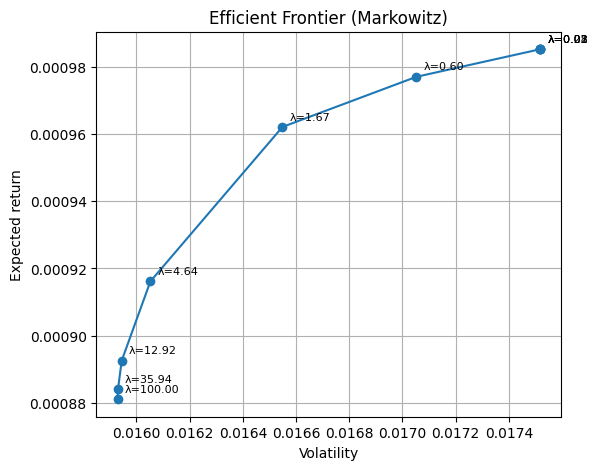

In [47]:
# TODO: visualize the portfolios using the helpers or use your own
labels = [f"λ={lam:.2f}" for lam in lams]

visualize_return_risk(
    returns=returns_list,
    variances=variances,
    labels=labels,
    use_volatility=True
)

---
## Task 3. Robust (adversarial) optimization

We now model uncertainty in predicted returns.

#### Uncertainty model

We assume the true return vector lies in an $\ell_2$-ball around the predicted value:
$$
\mu = \hat\mu + \delta,
\qquad
\|\delta\|_2 \le \epsilon.
$$

> Note this is NOT the same as the $\ell_\infty$-ball error described in the README. Convince yourself that they do not correspond to the same minimization problem.

The robust optimization problem is
$$
\begin{aligned}
\max_w \min_{\|\delta\|_2 \le \epsilon}
\;& (\hat\mu + \delta)^\top w - \lambda\, w^\top \Sigma w \\
\text{s.t. } & \mathbf{1}^\top w = 1,\quad w \ge 0.
\end{aligned}
$$

Interestingly, this reduces to the convex program
$$
\begin{aligned}
\max_w \;& \hat\mu^\top w - \epsilon \|w\|_2 - \lambda\, w^\top \Sigma w \\
\text{s.t. } & \mathbf{1}^\top w = 1,\quad w \ge 0.
\end{aligned}
$$

This allows us to easily implement it in cvxpy.

---

### Task 3.1 - Implement the robust Markowitz solver
Write a helper similar to task 2.1

In [48]:
def robust_markowitz(mu, Sigma, lam, eps):
    n = len(mu)
    w = cp.Variable(n)
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    objective = cp.Maximize(
        mu @ w
        - eps * cp.norm(w, 2)
        - lam * cp.quad_form(w, Sigma)
    ) 
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value

### Perturbation analysis

The robust formulation provides a worst-case guarantee.
We can analyze it with an empirical sensitivity experiment.

The goal is to sample perturbations $\delta$ uniformly from the $\ell_2$ ball of radius $\epsilon$ and evaluate portfolio performance under these perturbed returns.

> This is similar to the kind of analysis done using Monte Carlo methods

### Task 4.2 - Empirical robustness via perturbation analysis

For perturbing the returns vector use this helper `sample_l2_perturbations` to generate a 2D array of perturbed vectors - our samples.

> Specifically, we generate a random direction $u/||u||_2$ where $u \sim \mathcal{N}(0, I)$ and random length $d \sim \text{Uniform}(0,\epsilon)$


In [49]:
def sample_l2_perturbations(n, eps, num_samples, seed=None):
    """
    Sample perturbations uniformly from the l2 ball of radius eps.
    """
    if seed is not None:
        np.random.seed(seed)

    deltas = []
    radii = []
    for _ in range(num_samples):
        u = np.random.randn(n)
        u = u / np.linalg.norm(u)        # random direction
        r = np.random.uniform(0, eps)    # random radius
        deltas.append(r * u)
        radii.append(r)

    return np.array(deltas), np.array(radii)

Set $\lambda = 1.2, \epsilon = 0.1$, use $\text{num\_sample}=100$ and generate the portfolios and deltas.

In [52]:
# TODO: first run the markowitz_portfolio and robust_markowitz functions to get portfolios
# remember robust_markowitz takes an additional eps parameter
lam = 1.2
eps = 0.1
num_samples = 100

# solve portfolios
#...
# sample perturbations
# NOTE: use
#deltas, _ = sample_l2_perturbations(len(mu), eps, num_samples)
deltas, radii = sample_l2_perturbations(n=len(mu), eps=eps, num_samples=num_samples, seed=42)

Evaluate the portfolios under the list of perturbed means and collect results in 1D arrays `ret_std` and `ret_rob` (for eg).

In [56]:
# TODO: evaluate the portfolios under perturbations and collect results
w_std= markowitz_portfolio(mu, Sigma, lam)
w_rob= robust_markowitz(mu, Sigma, lam,eps)
# remember to use `mu_perturbed = mu + delta` for each delta in deltas
ret_std = []
ret_rob = []
for delta in deltas:
    mu_pert = mu + delta
    ret_std.append(mu_pert @ w_std)
    ret_rob.append(mu_pert @ w_rob)
ret_std = np.array(ret_std)
ret_rob = np.array(ret_rob)

Visualize your results and answer these questions:
- Plot histograms of the data points (realized portfolio returns) in both arrays and analyze visually. What do you observe?
- Print out summary statistics
    - Mean, Median, Worst (minimum return)

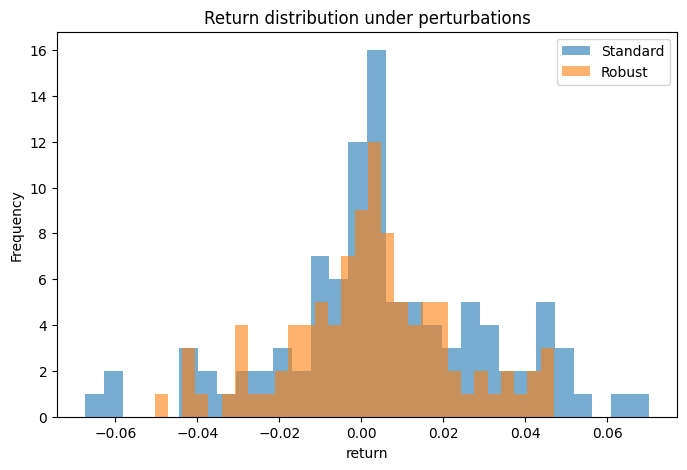

In [64]:
# TODO: visualize results
plt.figure(figsize=(8,5))
plt.hist(ret_std, bins=30, alpha=0.6, label="Standard")
plt.hist(ret_rob, bins=30, alpha=0.6, label="Robust")
plt.xlabel("return")
plt.ylabel("Frequency")
plt.title("Return distribution under perturbations")
plt.legend()
plt.show()

### Task 4.3 (Bonus) But how poorly does standard optimization do?
This analysis does not really show "how" the standard portfolio performance degrades as delta grows larger. For that we can make a scatter plot of the form
$$(||\delta||, \text{realized returns on } \hat\mu+\delta)$$
For both portfolios. Try doing this and analyzing the result. Helper code is given.

In [ ]:
# TODO: run the same code as above (perhaps different epsilons)

# visualize results
# NOTE: assumes radii, ret_std, ret_rob are defined from above code
plt.figure(figsize=(7, 4))
plt.scatter(radii, ret_std, alpha=0.5, label="Standard")
plt.scatter(radii, ret_rob, alpha=0.5, label="Robust")

plt.xlabel(r"$\|\delta\|_2$")
plt.ylabel("Realized return")
plt.title("Return degradation vs perturbation magnitude")
plt.legend()
plt.grid(True)
plt.show()